In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torchvision.utils as vutils

import os
import matplotlib.pyplot as plt
import numpy as np
import imageio

from tqdm.notebook import trange, tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
batch_size = 512

g_lr = 1e-4
d_lr = 1e-4

image_size = 32
data_set_root = "../../datasets"

In [ ]:
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=([0.5]), std=([0.5]))
                                ])

trainset = datasets.MNIST(data_set_root, train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:10<00:00, 904kB/s] 


Extracting ../../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ../../datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting ../../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ../../datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting ../../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.38MB/s]

Extracting ../../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../datasets/MNIST/raw



The Generator takes in a noise sample vector as an input and upsamples it until it is the desired size. After training, it should output a valid image

In [ ]:
class Generator(nn.Module):
  def __init__(self, in_channels=128, hidden_channels=32):
    super().__init__()

    self.conv_transpose_1 = nn.ConvTranspose2d(in_channels=in_channels,
                                               out_channels=(hidden_channels * 4),
                                               kernel_size=4,
                                               stride=1)

    self.conv_1 = nn.Conv2d(in_channels=(hidden_channels * 4),
                            out_channels=(hidden_channels * 4),
                            kernel_size=3,
                            stride=1,
                            padding=1)
    self.batch_norm_1 = nn.BatchNorm2d(hidden_channels * 4)

    self.conv_2 = nn.Conv2d(in_channels=(hidden_channels * 4),
                            out_channels=(hidden_channels * 2),
                            kernel_size=3,
                            stride=1,
                            padding=1)
    self.batch_norm_2 = nn.BatchNorm2d(hidden_channels * 2)

    self.conv_3 = nn.Conv2d(in_channels=(hidden_channels * 2),
                            out_channels=(hidden_channels * 2),
                            kernel_size=3,
                            stride=1,
                            padding=1)
    self.batch_norm_3 = nn.BatchNorm2d(hidden_channels * 2)

    self.conv_4 = nn.Conv2d(in_channels=(hidden_channels * 2),
                            out_channels=(hidden_channels * 2),
                            kernel_size=3,
                            stride=1,
                            padding=1)
    self.batch_norm_4 = nn.BatchNorm2d(hidden_channels * 2)

    self.conv_out = nn.Conv2d(in_channels=(hidden_channels * 2),
                              out_channels=1,
                              kernel_size=3,
                              stride=1,
                              padding=1)

    self.upsample = nn.Upsample(scale_factor=2, mode="nearest")

  def forward(self, x):
    x = F.elu(self.conv_transpose_1(x)) # (batch_size, 128, 1, 1) -> (batch_size, 128, 4, 4)
    x = self.upsample(F.elu(self.batch_norm_1(self.conv_1(x)))) # (batch_size, 128, 4, 4) -> (batch_size, 128, 8, 8)
    x = self.upsample(F.elu(self.batch_norm_2(self.conv_2(x)))) # (batch_size, 128, 8, 8) -> (batch_size, 64, 16, 16)
    x = self.upsample(F.elu(self.batch_norm_3(self.conv_3(x)))) # (batch_size, 64, 16, 16) -> (batch_size, 64, 32, 32)
    x = F.elu(self.batch_norm_4(self.conv_4(x))) # (batch_size, 64, 32, 32) -> (batch_size, 64, 32, 32)

    # Go from random noise to an image with the correct dimensions
    return torch.tanh(self.conv_out(x)) # (batch_size, 64, 32, 32) -> (batch_size, 1, 32, 32)

The Discriminator is convolutional classifier network that has a single output.

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, hidden_channels=32):
    super().__init__()

    self.conv_in = nn.Conv2d(in_channels=1,
                             out_channels=hidden_channels,
                             kernel_size=3,
                             stride=1,
                             padding=1)

    self.conv_1 = nn.Conv2d(in_channels=hidden_channels,
                            out_channels=(hidden_channels * 2),
                            kernel_size=3,
                            stride=2,
                            padding=1)

    self.conv_2 = nn.Conv2d(in_channels=(hidden_channels * 2),
                            out_channels=(hidden_channels * 2),
                            kernel_size=3,
                            stride=2,
                            padding=1)

    self.conv_3 = nn.Conv2d(in_channels=(hidden_channels * 2),
                            out_channels=(hidden_channels * 4),
                            kernel_size=3,
                            stride=2,
                            padding=1)

    self.conv_4 = nn.Conv2d(in_channels=(hidden_channels * 4),
                            out_channels=(hidden_channels * 4),
                            kernel_size=3,
                            stride=2,
                            padding=1)

    self.batch_norm = nn.BatchNorm2d(hidden_channels * 4)

    self.dropout = nn.Dropout(p=0.5)

    self.conv_5 = nn.Conv2d(in_channels=(hidden_channels * 4),
                            out_channels=1,
                            kernel_size=2,
                            stride=1)

  def forward(self, x):
    x = F.elu(self.conv_in(x)) # (batch_size, 1, 32, 32) -> (batch_size, 32, 32, 32)
    x = F.elu(self.conv_1(x)) # (batch_size, 32, 32, 32) -> (batch_size, 64, 16, 16)
    x = F.elu(self.conv_2(x)) # (batch_size, 64, 16, 16) -> (batch_size, 64, 8, 8)
    x = F.elu(self.conv_3(x)) # (batch_size, 64, 8, 8) -> (batch_size, 128, 4, 4)
    x = self.dropout(F.elu(self.batch_norm(self.conv_4(x)))) # (batch_size, 128, 4, 4) -> (batch_size, 128, 2, 2)
    x = self.conv_5(x) # (batch_size, 128, 2, 2) -> (batch_size, 1, 1, 1)
    x = x.squeeze(dim=-1).squeeze(dim=-1) # (batch_size, 1, 1, 1) -> (batch_size, 1)
    return x

GANs are often described as a minimax game in which $G$ wants to minimize $V$.

**This means that in training, we first pass the output of the generator on a random noise sample through the generator to get an image. We then pass the image through the discriminator to get the probability that it is real or fake, and compare it to a vector of 1s. This means that in backpropagation, the generator is trying to make images that when passed through the discriminator, output 1s.**

**We then take the real image and pass it through the discriminator and compare it against a vector of 1s because we know that it is real. We then take the generated image from above and pass it through the discrimnator and compare it against a vector of 0s because we know that it is fake. Through backpropagation, this makes the discriminator learn the differences between fake and real images.**

$$
\min_G\max_DV(D, G) = \mathbb{E}_{x \sim  p_{data}(x)}[log(D(x))] + \mathbb{E}_{z \sim p_z(z)}[log(1 - D(G(z))]
$$

Where:

- **$V$** is the objective function that we want to maximize
- $D(x)$ is the discriminator’s estimate of the probability that $x$ is a real data sample.
- $G(z)$ is the generator’s output when given noise $z$.
- $D(G(z))$ is the discriminator’s estimate of the probability that the output of the generator when given noise $z$ is a real data sample.
- $x \sim  p_{data}(x)$ is a real image drawn from the dataset
- $z \sim p_z(z)$ is a random noise vector that has been sampled from a standard distribution
- $\mathbb{E}_{x \sim  p_{data}(x)}[log(D(x))]$ recognizes real images
- $\mathbb{E}_{z \sim p_z(z)}[log(1 - D(G(z))]$ recognizes generated images
- $\log(D(x))$ takes the log of the probability meaning that if $D(x)$ is high , the log value is near $0$, which is good for $D$. If $D(x)$ is low, the log value becomes very negative, which penalizes the discriminator.
- $\log(1 - D(G(z)))$ means that if $D(G(z))$ is low meaning that the discriminator correctly identified the fake image, then $1 - D(G(z))$ is high and its logarithm is less negative. Conversely, if $D(G(z))$ is high, the logarithm becomes very negative, which is bad for the discriminator.

**The discriminator is rewarded (maximized) when it assigns a high probability to real images.**

**The discriminator is rewarded when it correctly identifies fake images as fake.**

**While the discriminator is trying to maximize the whole value function (improving its ability to tell real from fake), the generator is trying to minimize the value function.**

Once both objective functions are defined, they are learned jointly by the alternating gradient descent algorithm. We fix the generator model’s parameters and perform a single iteration of gradient ascend on the discriminator using the real and the generated images. Then we switch sides. Fix the discriminator and train the generator for another single iteration. We train both networks in alternating steps until the generator produces good-quality images. The following summarizes the data flow and the gradients used for the backpropagation.

In [ ]:
def gan_bce_loss(output, real_label=True):
  if real_label:
    # Compare with a tensor of 1s when real
    return F.binary_cross_entropy_with_logits(output, torch.ones_like(output))
  else:
    # Compare with a tensor of 0s when fake
    return F.binary_cross_entropy_with_logits(output, torch.zeros_like(output))

In [ ]:
noise_dim = 128

epochs = 100

generator = Generator(in_channels=noise_dim, hidden_channels=32).to(device)
discriminator = Discriminator(hidden_channels=32).to(device)

# A fixed latent noise vector so we can see the improvement over the epochs
fixed_latent_noise = torch.randn(16, noise_dim, 1, 1).to(device) # (batch_size=16, 128, 1, 1)

optimizer_g = optim.Adam(params=generator.parameters(), lr=g_lr)
optimizer_d = optim.Adam(params=discriminator.parameters(), lr=d_lr)

In [ ]:
generator_model_path = "mnist_gan_generator.pt"
discriminator_model_path = "mnist_gan_discriminator.pt"

if os.path.exists(generator_model_path):
  print(f"Loading generator from {generator_model_path}...")
  generator.load_state_dict(torch.load(generator_model_path, map_location=device))

if os.path.exists(discriminator_model_path):
  print(f"Loading discriminator from {discriminator_model_path}...")
  discriminator.load_state_dict(torch.load(discriminator_model_path, map_location=device))

d_out_fake = []
d_out_real = []

g_loss = 0
d_loss = 0

train = False

Loading generator from mnist_gan_generator.pt...
Loading discriminator from mnist_gan_discriminator.pt...


<ipython-input-10-fbbeb7ecdfdd>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(generator_model_path, map_location=device))
<ipython-in

In [ ]:
if train:
  pbar = trange(epochs, leave=False, desc="Epoch")

  generator.train()

  for epoch in pbar:
    pbar.set_postfix_str(f"G Loss: {g_loss / len(dataloader)} | D Loss: {d_loss / len(dataloader)}")
    g_loss = 0
    d_loss = 0

    for i, (images, label) in enumerate(tqdm(dataloader, leave=False)):
      images = images.to(device)

      batch_size = images.shape[0]

      # Generator

      # Sample a random noise vector from a standard distribution and pass it through the generator
      latent_noise = torch.randn(batch_size, noise_dim, 1, 1).to(device)
      output_g = generator(latent_noise)

      # Pass the generator output through the discriminator and calculate the loss against the real label because we want the discriminator to think the outputs are real
      output_d = discriminator(output_g)
      loss_g = gan_bce_loss(output=output_d, real_label=True)

      optimizer_g.zero_grad()
      loss_g.backward()
      optimizer_g.step()

      g_loss += loss_g.item()

      # Discriminator

      # Pass the real images through the Discriminator and calculate the loss against the real label
      output_real_d = discriminator(images)
      loss_real_d = gan_bce_loss(output=output_real_d, real_label=True)
      d_out_real.append(loss_real_d.mean().item())

      # Pass the fake images from the Generator through the Discriminator and calculate the loss against the fake label
      output_fake_d = discriminator(output_g.detach())
      loss_fake_d = gan_bce_loss(output=output_fake_d, real_label=False)
      d_out_fake.append(loss_fake_d.mean().item())

      # Average the losses and backpropogate through the discriminator
      loss_d = (loss_real_d + loss_fake_d) / 2

      optimizer_d.zero_grad()
      loss_d.backward()
      optimizer_d.step()

      d_loss += loss_d.item()

    torch.save(generator.state_dict(), generator_model_path)
    torch.save(discriminator.state_dict(), discriminator_model_path)

In [ ]:
fixed_latent_noise.shape

torch.Size([16, 128, 1, 1])

torch.Size([16, 1, 32, 32])


(-0.5, 137.5, 137.5, -0.5)

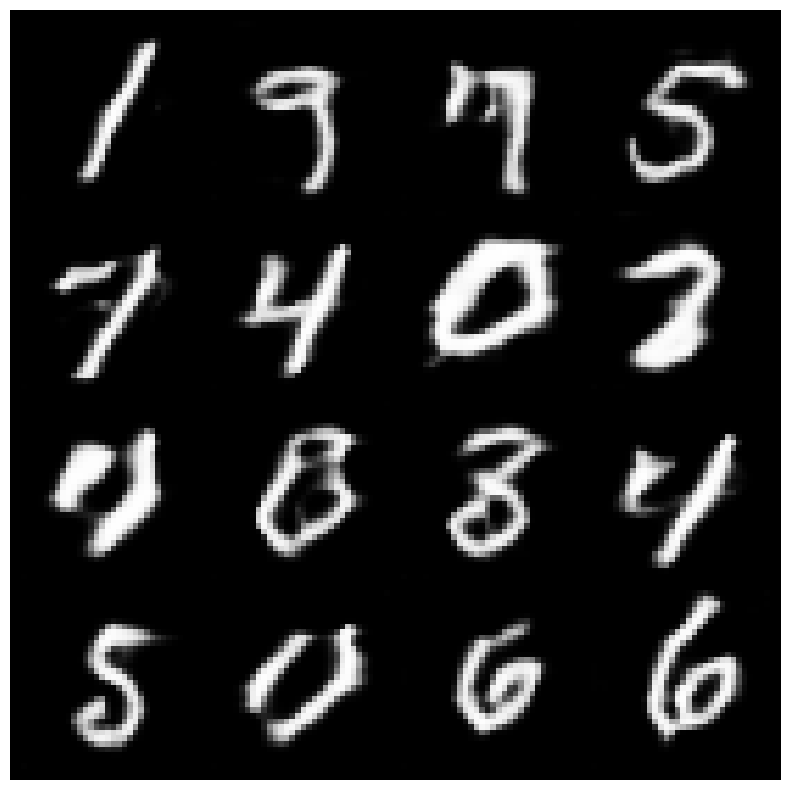

In [ ]:
test_fake = generator(fixed_latent_noise)
print(test_fake.shape)

plt.figure(figsize=(20, 10))
out = vutils.make_grid(test_fake.detach().cpu(), 4, normalize=True)

plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.axis(False)

(-0.5, 137.5, 137.5, -0.5)

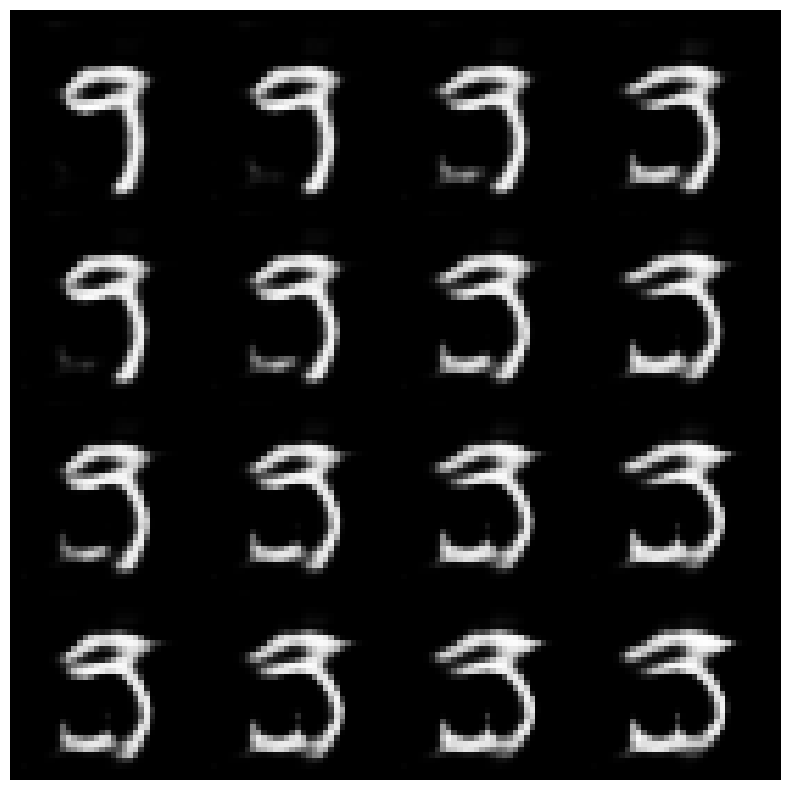

In [ ]:
generated_images = []

for x in range(4):
  for y in range(4):
    noise = fixed_latent_noise[1].clone().detach()

    dim_x = 7
    dim_y = 1

    noise[dim_x] = noise[dim_x] + x * torch.ones_like(noise[dim_x])
    noise[dim_y] = noise[dim_y] + y * torch.ones_like(noise[dim_y])
    new_img = generator(noise.unsqueeze(dim=0))

    generated_images.append(new_img)

plt.figure(figsize=(20, 10))
out = vutils.make_grid(torch.cat(generated_images).detach().cpu(), 4, normalize=True)

plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.axis(False)